TODO: Histogram Equalization a

TODO: Exact Cropping

TODO: Other datasets

TODO: Hog

TODO: BRIEF
.
.
.


TODO: Image preprocessing to decrease effect of light

TODO: Try different image size

TODO: Try different features than HOG and try different HOG settings

TODO: Distribution can we do it without pca? is it correct? can we do the other term?

TODO: Should we do pca on features? Normalization?

TODO: Parameters cross validaton

TODO: Validating different steps

TODO: Split the data and calculate test accuracy

TODO: Check padding of cropping

TODO: Can we cache features extracted? 

In [1]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import ast
import os
from preprocessor import *
from feature_extractor import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import math
import time
import joblib
from enum import Enum

c:\Users\ammar\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [60]:
CreateCSVFromAnnotations68("ibug","ibug_test.csv")

In [62]:
CropAndResizeDataset("ibug_dataset/ibug_test.csv", "ibug/", "ibug_dataset/testset/", "ibug_dataset/croppedibug_test.csv")

In [2]:
# CropAndResizeDataset("lfpw/lfpw_train.csv", "lfpw/trainset/", "lfpw/cropped2lfpw/trainset/", "lfpw/cropped2lfpw_train.csv")
# CropAndResizeDataset("lfpw/lfpw_test.csv", "lfpw/testset/", "lfpw/cropped2lfpw/testset/", "lfpw/cropped2lfpw_test.csv")

# CropAndResizeDataset("300w/300w_train.csv", "300w/trainset/", "300w/cropped2300w/trainset/", "300w/cropped2300w_train.csv")
# CropAndResizeDataset("300w/300w_test.csv", "300w/testset/", "300w/cropped2300w/testset/", "300w/cropped2300w_test.csv")
                     
# CropAndResizeDataset("helen/helen68_train.csv", "helen/trainset/", "helen/cropped2helen/trainset/", "helen/cropped2helen_train.csv")
# CropAndResizeDataset("helen/helen68_test.csv", "helen/testset/", "helen/cropped2helen/testset/", "helen/cropped2helen_test.csv")
                     
# CropAndResizeDataset("afw/afw_train.csv", "afw/trainset/", "afw/cropped2afw/trainset/", "afw/cropped2afw_train.csv")
# CropAndResizeDataset("afw/afw_test.csv", "afw/testset/", "afw/cropped2afw/testset/", "afw/cropped2afw_test.csv")

In [3]:
df = pd.read_csv('combined/combined_train.csv')

In [4]:
df.head()

,images,landmarks
0,100032540_1.jpg,"[[16, 82], [17, 102], [18, 122], [20, 140], [2..."
1,100040721_1.jpg,"[[17, 87], [16, 107], [18, 128], [23, 148], [3..."
2,100040721_2.jpg,"[[16, 84], [22, 107], [29, 132], [35, 150], [4..."
3,1002681492_1.jpg,"[[18, 80], [16, 96], [17, 114], [21, 132], [28..."
4,1004467229_1.jpg,"[[24, 61], [20, 85], [19, 107], [17, 129], [16..."


Show image with landmarks

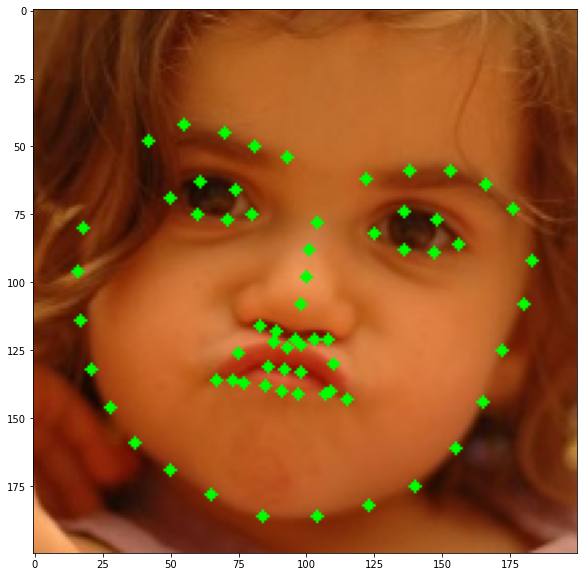

In [5]:
imgname = '1002681492_1.jpg'
landmarks= ast.literal_eval(df.loc[df['images'] == imgname].iloc[0]['landmarks'])
img = cv2.imread('combined/trainset/'+imgname)
for i in range(0,68):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 2, (0, 255, 0), -1)
# cv2.circle(img, (landmarks[38][0],landmarks[38][1]), 3, (0, 255, 0), -1)
# cv2.circle(img, (landmarks[51][0],landmarks[51][1]), 3, (0, 255, 0), -1)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

#right eye start is 38
#right eye end is 42
#left eye start is 48
#left eye end is 51

In [6]:
class FeatureType(Enum):
    HOG = 1
    SIFT = 2
    ORB = 3

TRAINING

In [7]:
#PARAMETERS

L = 3 ##number of iterations

featuresUsed = [FeatureType.HOG, FeatureType.HOG, FeatureType.SIFT] #[FeatureType.HOG, FeatureType.SIFT]

K = 3 #number of regressors in each iteration

sampleSize = 5 #15

#Ridge regularization parameter
alpha = 10000 #1000

alpha_sift = 100000

B = 1 #1 #Affinity matrix similarity

T = 10#10 #Iterations for updating weights

assert len(featuresUsed) == L

Initializations

In [8]:
# df = pd.read_csv('datasets/croppedHelen200_65.csv')
# imagesPath = 'datasets/croppedHelen200/'

df_train = pd.read_csv('combined/combined_train.csv')
df_test = pd.read_csv('combined/combined_test.csv')
imagesPath_train = 'combined/trainset/'
imagesPath_test = 'combined/testset/'

outputpath = 'models'
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
numModels = len(os.listdir(outputpath))
outputpath = outputpath+'/model'+str(numModels)
os.makedirs(outputpath)


landmarkslist_train = df_train['landmarks'].values.tolist()
landmarks_dataset_train = np.array([ast.literal_eval(x) for x in landmarkslist_train])

landmarkslist_test = df_test['landmarks'].values.tolist()
landmarks_dataset_test = np.array([ast.literal_eval(x) for x in landmarkslist_test])

#reshape landmarks to one vector
landmarks_dataset_train = landmarks_dataset_train.reshape(landmarks_dataset_train.shape[0],landmarks_dataset_train.shape[1]*2)
landmarks_dataset_test = landmarks_dataset_test.reshape(landmarks_dataset_test.shape[0],landmarks_dataset_test.shape[1]*2)

#Split to train and test
# trainLength = 2000
# landmarks_train = landmarks_dataset[:trainLength]
# images_train = df['images'].values.tolist()[:trainLength]
# landmarks_test = landmarks_dataset[trainLength:]
# images_test = df['images'].values.tolist()[trainLength:]

images_train = df_train['images'].values.tolist()
images_test = df_test['images'].values.tolist()

candidate_shapes = landmarks_dataset_train

resized_ground_truth = np.repeat(candidate_shapes,sampleSize,axis=0).reshape(candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1])


x_bar_initial = candidate_shapes.mean(axis=0)
np.savez_compressed(outputpath+'/mean_shape.npz', shape=x_bar_initial)
#Set x_bar to be the same for all images as x_bar_initial, x_bar shape is (imagesSize, x_bar_initial.shape[0])
x_bar = np.tile(x_bar_initial, (candidate_shapes.shape[0],1))

#initial Probability distrubtions, set as uniform, shape is (imagesSize, imagesSize)
probabilities = np.ones((candidate_shapes.shape[0],candidate_shapes.shape[0]))/candidate_shapes.shape[0]

regressors = []
pcaModels = []
standardScalarModels = []

normalizedErrors = []

#Report file
#Get current number of files in reports folder
reportName = outputpath+'/report.txt'
report = open(reportName, "w")
report.write('Parameters:\n')
# report.write('Without replacement:\n')
#report.write('With replacement in last and adding small noise\n')
#report.write('Trying not to resample in last iteration\n')

report.write("Histogram Equalization used\n")

report.write('L = '+str(L)+'\n')
report.write('K = '+str(K)+'\n')
report.write('sampleSize = '+str(sampleSize)+'\n')
report.write('alpha = '+str(alpha)+'\n')
report.write('alpha_sift = '+str(alpha_sift)+'\n')
report.write('Features Used = '+str(featuresUsed)+'\n')
report.write('B = '+str(B)+'\n')
report.write('T = '+str(T)+'\n')
report.write('trainLength = '+str(len(images_train))+'\n')
report.write('imagesPath = '+imagesPath_train+'\n\n')
report.write("Models path: "+outputpath+'\n')
report.write("X_bar path: "+'mean_shape.npz'+'\n\n')


28

In [9]:
rightEyeStartIndex = 36
rightEyeEndIndex = 39
leftEyeStartIndex = 42
leftEyeEndIndex = 45

#Calculate normalized error between predicted shape and ground truth
def calc_normalized_error_single_image(predicted_shape, ground_truth):
    '''For Single Image'''
    predicted_shape = predicted_shape.reshape(-1,2)
    ground_truth = ground_truth.reshape(-1,2)
    leftPupilCoordinates = ((ground_truth[leftEyeStartIndex]+ground_truth[leftEyeEndIndex])/2).round().astype(int)
    rightPupilCoordinates = ((ground_truth[rightEyeStartIndex]+ground_truth[rightEyeEndIndex])/2).round().astype(int)
    interpupilary_distance = np.linalg.norm(leftPupilCoordinates-rightPupilCoordinates)

    #normalized error is the euclidean distance between the predicted shape and the ground truth divided by the interocular distance
    error = np.average(np.linalg.norm(predicted_shape-ground_truth, axis=1)/interpupilary_distance)
    return error

#For list of images
def calc_total_error(predicted_shapes, ground_truths):
    assert predicted_shapes.shape == ground_truths.shape

    totalError = 0
    for i in range(0,len(predicted_shapes)):
        totalError += calc_normalized_error_single_image(predicted_shapes[i], ground_truths[i])
    return totalError/len(predicted_shapes)

In [10]:
def getSamplesForEachImage(candidate_shapes, probabilities, sampleSize=15, replace=False):
    np.random.seed(21)
    rng = np.random.default_rng()
    sampled_shapes =rng.choice(candidate_shapes, sampleSize, replace=replace, p=probabilities) #TODO should we sample with replacement?
    return sampled_shapes

In [11]:
#Function to calculate affinity matrix A for each image such that A is of size (sampleSize,sampleSize)
def CalcAffinityMatrix(samples, B=B): #TODO CHOOSE B, note in gaussian kernel, B is the inverse of the variance, higher B means more sensitive to differences
    AffinityMatrices = np.zeros((samples.shape[0],sampleSize,sampleSize))
    for index,sampleVector in enumerate(samples):
        A = np.zeros((sampleSize,sampleSize))
        for i in range(0,sampleSize):
            for j in range(0,sampleSize):
                A[i,j] = 0 if i==j else np.exp(-B * np.linalg.norm(sampleVector[i]-sampleVector[j]))
        AffinityMatrices[index] = A
    return AffinityMatrices

In [12]:
def UpdateWeights(weights, samples, T=T, B=B):
    AffinityMatrices = CalcAffinityMatrix(samples, B=B)
    for t in range(T):
        for index,A in enumerate(AffinityMatrices):
            weights[index] = (np.multiply(weights[index], np.dot(A, weights[index]))) / (np.matmul(weights[index].T, np.dot(A, weights[index])))
    return weights

In [13]:
def calculateDistribution(x_bar, candidate_shapes=candidate_shapes):
    differences = np.tile(x_bar, (len(candidate_shapes), 1)) - candidate_shapes
    # differences_std = (differences - np.mean(differences, axis=0)) / np.std(differences, axis=0)
    # pca = PCA()
    # pca.fit(differences_std)
    # normalized_differences = pca.transform(differences_std)
    #Get decorrelated covariance matrix
    #cov =  np.diag(np.var(normalized_differences, axis=0))
    cov =  np.diag(np.var(differences, axis=0))

    # distribution = np.zeros((candidate_shapes.shape[0],1))
    # distribution = [np.exp(-0.5 * np.matmul(np.matmul((normalized_differences[i]).T, np.linalg.inv(cov)), (normalized_differences[i]))) for i in range(len(landmarks_dataset))]
    inv_cov = np.linalg.inv(cov)
    #temp = np.matmul(normalized_differences, inv_cov)
    temp = np.matmul(differences, inv_cov)

    exponent = -0.5 * np.sum(temp * differences, axis=1)
    #exponent = -0.5 * np.sum(temp * normalized_differences, axis=1)

    distribution = np.exp(exponent)

    #normalize distribution
    distribution = distribution / np.sum(distribution)
    return distribution

In [14]:
def calculateTestAccuracy(landmarks_test, images_test, x_bar_initial, regressors, featuresUsed, pcamodels=None, standardModels=None):
    x_bar_initial = x_bar_initial.reshape(68,2).round().astype(int)
    x_bar = np.tile(x_bar_initial, (landmarks_test.shape[0],1))

    predicted_shapes = x_bar
    predicted_shapes = predicted_shapes.reshape((landmarks_test.shape[0],68,2))

    
    L_stages = int(len(regressors)/3)
    assert len(featuresUsed) == L_stages

    siftStartIndex=None
    for l in range(L_stages):
        if FeatureType.SIFT == featuresUsed[l]:
            siftStartIndex = l*3
            break

    #for i in range(len(landmarks_test)):
        #predicted_shape = x_bar
    for index, regressor in enumerate(regressors):
        #extract hog features from predicted_shape
        if pcamodels is not None and featuresUsed[index//3] == FeatureType.SIFT:
            features = np.array([getSiftFromLandmarks(predicted_shapes[i], cv2.imread(imagesPath_test+images_test[i])) for i in range(0, predicted_shapes.shape[0])]) 
            pcaIndex = 0 if siftStartIndex == 0 else index%siftStartIndex
            features = standardModels[pcaIndex].transform(features)
            features = pcamodels[pcaIndex].transform(features)
        elif featuresUsed[index//3] == FeatureType.ORB:
            features = np.array([getORBFromLandmarks(predicted_shapes[i], cv2.imread(imagesPath_test+images_test[i])) for i in range(0, predicted_shapes.shape[0])]) 
        else:
            features = np.array([getHogFromLandmarks(predicted_shapes[i], cv2.imread(imagesPath_test+images_test[i])) for i in range(0, predicted_shapes.shape[0])]) 


        #hog_features = getSiftFromLandmarks(predicted_shape, img)
        offset = regressor.predict(features)
        predicted_shapes = predicted_shapes + offset.reshape((landmarks_test.shape[0],68,2))
        predicted_shapes = predicted_shapes.round().astype(int)
        #predicted_shapes.append(predicted_shape)
    return calc_total_error(predicted_shapes.reshape(predicted_shapes.shape[0], predicted_shapes.shape[1]*predicted_shapes.shape[2]), landmarks_test)

In [15]:
regressedShapes = []

In [16]:
samplesList = []

In [17]:
for l in range(L):

    #startiteration = time.time()

    # Your code here
    report.write("Iteration "+str(l+1)+"\n")
    print("Iteration "+str(l+1)+"\n")

    withreplacement = False #True if l == 2 else False

    #samples = np.zeros((candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1]))
    #For each image in candidate_shapes, we sample 15 possible shapes to get a result shape of (candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1])
    
    samples = np.array([getSamplesForEachImage(candidate_shapes, sampleSize=sampleSize, probabilities=probabilities[i], replace=withreplacement) for i in range(0,candidate_shapes.shape[0])])

    #samplesList.append(samples)

    # if l==1:
    #     break
    # if l==2:
    #     randomError = np.random.randint(-3,3, size=samples.shape).astype(int)
    #     samples +=randomError.round()

    #Calculate Error at beginning of iteration after sampling
    error = calc_total_error(samples, resized_ground_truth)
    report.write("Iteration "+str(l+1)+" Error after sampling: "+ str(error)+'\n')  
    print("Iteration "+str(l+1)+" Error after sampling: "+ str(error)+'\n')       


    for k in range(K):

        print("K: ", k+1)
        report.write("K: "+str(k+1)+"\n")
        
        #calculating labels for each sample where the label is the difference between the sample and the ground truth of the corresponing image
        labels = candidate_shapes[:,np.newaxis,:] - samples
        assert (labels[sampleSize,3,:] == (candidate_shapes[sampleSize,:] - samples[sampleSize,3,:])).all()
        labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2])

        print("Feature Extraction...")
        #startfeatures = time.time()
        #Now we calculate the feature vector for each sample shape using hog function getHogFromLandmarks
        if featuresUsed[l] == FeatureType.HOG:
            print("HOG")
            features = np.array([[getHogFromLandmarks(samples[i,j].reshape(68,2), cv2.imread(imagesPath_train+images_train[i])) for j in range(0,sampleSize)] for i in range(0,candidate_shapes.shape[0])])
            features = features.reshape(features.shape[0]*features.shape[1],features.shape[2])
        elif featuresUsed[l] == FeatureType.ORB:
            features = np.array([[getORBFromLandmarks(samples[i,j].reshape(68,2), cv2.imread(imagesPath_train+images_train[i])) for j in range(0,sampleSize)] for i in range(0,candidate_shapes.shape[0])])
            features = features.reshape(features.shape[0]*features.shape[1],features.shape[2])
        elif featuresUsed[l] == FeatureType.SIFT:
            print("Using SIFT")
            features = np.array([[getSiftFromLandmarks(samples[i,j].reshape(68,2), cv2.imread(imagesPath_train+images_train[i])) for j in range(0,sampleSize)] for i in range(0,candidate_shapes.shape[0])])
            features = features.reshape(features.shape[0]*features.shape[1],features.shape[2])
            #Apply pca on features
            print("standardization")
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
            standardScalarModels.append(scaler)

            print("PCA")
            pca = PCA(n_components=2176)
            features = pca.fit_transform(features)
            pcaModels.append(pca)

            report.write("PCA components: "+str(features.shape[1])+"\n")
            print("PCA components: ", features.shape[1])
           
        #features = np.array([[getSiftFromLandmarks(samples[i,j].reshape(68,2), cv2.imread(imagesPath+images_train[i])) for j in range(0,sampleSize)] for i in range(0,candidate_shapes.shape[0])])
        #assert features.shape == (candidate_shapes.shape[0],sampleSize, 68*2*16) #last number depends on hog parameters
        #endfeatures = time.time()
        #print("Feature Extraction time: ", endfeatures-startfeatures)

    


        assert features.shape[0] == labels.shape[0]

        print("Training regressor...")

        #startraining = time.time()
        #Train regressor with l2 regularization
        usedalpha = alpha_sift if FeatureType.SIFT == featuresUsed[l] else alpha
        reg = Ridge(alpha).fit(features, labels)
        #endtraining = time.time()
        #print("Training time: ", endtraining-startraining)

        regressors.append(reg)

        #update samples with the offset calculated from predicted values
        predicted_labels = reg.predict(features)
        predicted_labels = predicted_labels.reshape(candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1])
        samples = samples + predicted_labels
        #regressedShapes.append(samples)
        #round samples to integers
        samples = np.round(samples).astype(int)

        #startError = time.time()
        trainingError = calc_total_error(samples, resized_ground_truth)
        #endError = time.time()
        #print("Error calculation time: ", endError-startError)

        normalizedErrors.append(trainingError)

        #Print total normalized error
        print("Error after iteration l=",l+1,", regressor k=",k+1,": ",trainingError)
        report.write("Error after iteration l="+str(l+1)+", regressor k="+str(k+1)+": "+str(trainingError)+'\n')

    
    if l < L-1:
        print("Updating distributions...")
        #startDistribution = time.time()
        #Create a weight vector of length sampleSize for each image, initially set to e/SampleSize
        weights = np.ones((candidate_shapes.shape[0],sampleSize, 1)) * (1/sampleSize)

        #Updating weights
        updated_weights = UpdateWeights(weights, samples)

        #Update x_bar using updated weights and regressed samples
        x_bar = np.zeros((candidate_shapes.shape[0],candidate_shapes.shape[1]))
        for index,weight in enumerate(updated_weights):
            x_bar[index] = np.matmul(weight.T, samples[index])

        probabilities = np.array([calculateDistribution(x_bar[i]) for i in range(0,x_bar.shape[0])])

        #endDistribution = time.time()
        #print("Distribution update time: ", endDistribution-startDistribution)
    
    #enditeraton = time.time()

    #print("Time for iteration: ",l+1, enditeraton-startiteration)


#calculate test error
#starttesttime = time.time()
testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors, featuresUsed, pcaModels, standardScalarModels)
print("Test error on all datasets: ", testError)
report.write("Test error on all datasets: "+str(testError)+'\n')

df_test = pd.read_csv('300w/cropped300w_test.csv')
images_test = df_test['images'].values
landmarkslist_test = df_test['landmarks'].values.tolist()
landmarks_dataset_test = np.array([ast.literal_eval(x) for x in landmarkslist_test])
landmarks_dataset_test = landmarks_dataset_test.reshape(landmarks_dataset_test.shape[0],landmarks_dataset_test.shape[1]*2)

testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors, featuresUsed, pcaModels, standardScalarModels)
print("Test error on 300w: ", testError)
report.write("Test error 300w: "+str(testError)+'\n')

df_test = pd.read_csv('lfpw/croppedlfpw_test.csv')
images_test = df_test['images'].values
landmarkslist_test = df_test['landmarks'].values.tolist()
landmarks_dataset_test = np.array([ast.literal_eval(x) for x in landmarkslist_test])
landmarks_dataset_test = landmarks_dataset_test.reshape(landmarks_dataset_test.shape[0],landmarks_dataset_test.shape[1]*2)

testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors, featuresUsed, pcaModels, standardScalarModels)
print("Test error on lfpw: ", testError)
report.write("Test error lfpw: "+str(testError)+'\n')

df_test = pd.read_csv('afw/croppedafw_test.csv')
images_test = df_test['images'].values
landmarkslist_test = df_test['landmarks'].values.tolist()
landmarks_dataset_test = np.array([ast.literal_eval(x) for x in landmarkslist_test])
landmarks_dataset_test = landmarks_dataset_test.reshape(landmarks_dataset_test.shape[0],landmarks_dataset_test.shape[1]*2)

testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors, featuresUsed, pcaModels, standardScalarModels)
print("Test error on afw: ", testError)
report.write("Test error afw: "+str(testError)+'\n')

df_test = pd.read_csv('helen/croppedhelen_test.csv')
images_test = df_test['images'].values
landmarkslist_test = df_test['landmarks'].values.tolist()
landmarks_dataset_test = np.array([ast.literal_eval(x) for x in landmarkslist_test])
landmarks_dataset_test = landmarks_dataset_test.reshape(landmarks_dataset_test.shape[0],landmarks_dataset_test.shape[1]*2)

testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors, featuresUsed, pcaModels, standardScalarModels)
print("Test error on helen: ", testError)
report.write("Test error helen: "+str(testError)+'\n')


# testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors[0:3], featuresUsed[0:1])
# print("Test error on first 3: ", testError)
# report.write("Test error on first 3: "+str(testError)+'\n')

# testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors[3:6], featuresUsed[1:2])
# print("Test error on 3-6 regressors: ", testError)
# report.write("Test error on 3-6 regressors: "+str(testError)+'\n')

# testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors[6:9], featuresUsed[2:3], pcaModels, standardScalarModels)
# print("Test error on last 3 regressors: ", testError)
# report.write("Test error on last 3 regressors: "+str(testError)+'\n')

# testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors[0:6], featuresUsed[0:2])
# print("Test error on 0-6: ", testError)
# report.write("Test error on 0-6: "+str(testError)+'\n')

# testError = calculateTestAccuracy(landmarks_dataset_test, images_test, x_bar_initial, regressors[3:9], featuresUsed[1:3], pcaModels, standardScalarModels)
# print("Test error on 3-9: ", testError)
# report.write("Test error on 3-9: "+str(testError)+'\n')


# endtesttime = time.time()

# print("Test error calculation time: ", endtesttime-starttesttime)

#Save models
#Create directory for models

for index,reg in enumerate(regressors):
    filename = outputpath+'/regressor'+str(index)+'.pkl'
    joblib.dump(reg, filename)

for index,pca in enumerate(pcaModels):
    filename = outputpath+'/pca'+str(index)+'.pkl'
    joblib.dump(pca, filename)

for index,scaler in enumerate(standardScalarModels):
    filename = outputpath+'/scaler'+str(index)+'.pkl'
    joblib.dump(scaler, filename)

report.close()




Iteration 1



Iteration 1 Error after sampling: 0.3750634330944262

K:  1
Feature Extraction...
HOG
Training regressor...
Error after iteration l= 1 , regressor k= 1 :  0.2905285416417124
K:  2
Feature Extraction...
HOG
Training regressor...
Error after iteration l= 1 , regressor k= 2 :  0.24763622052632978
K:  3
Feature Extraction...
HOG
Training regressor...
Error after iteration l= 1 , regressor k= 3 :  0.2223261797114388
Updating distributions...
Iteration 2



AssertionError: 

In [19]:
len(samplesList)

2

In [20]:
samplesList[0].shape

(3611, 5, 136)

In [23]:
images_train[0]

'100032540_1.jpg'

In [72]:
sample1 = samplesList[1][41][0].reshape(68,2)
sample2 = samplesList[1][41][1].reshape(68,2)
sample3 = samplesList[1][41][2].reshape(68,2)
sample4 = samplesList[1][41][3].reshape(68,2)

In [67]:
regressed1 = np.round(regressedShapes[2][41][0].reshape(68,2)).astype(int)
regressed2 = np.round(regressedShapes[2][41][1].reshape(68,2)).astype(int)
regressed3 = np.round(regressedShapes[2][41][2].reshape(68,2)).astype(int)
regressed4 = np.round(regressedShapes[2][41][3].reshape(68,2)).astype(int)

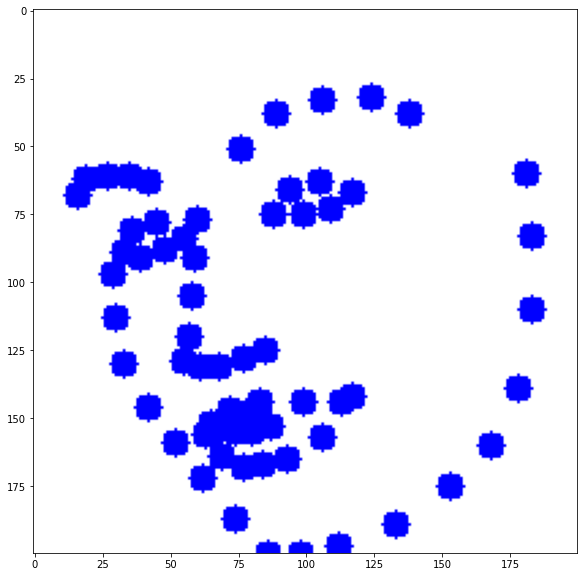

In [76]:
landmarks = sample4

image = cv2.resize(cv2.imread('Untitled.png'), (200,200))

for i in range(0,68):
  cv2.circle(image, (landmarks[i][0],landmarks[i][1]), 5, (0, 0, 255), -1)

fig = plt.figure(figsize=(10,10))
plt.imshow(image)

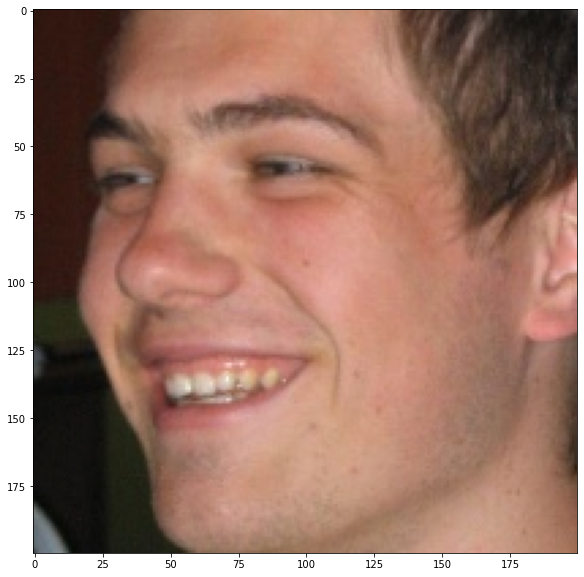

In [2]:
modelspath = 'models/model63'
loadedregressors = []
loadedStandardModels = []
loadedPCAModels = []
for index in range(0,9):
    filename = modelspath+'/regressor'+str(index)+'.pkl'
    loadedregressors.append(joblib.load(filename))

for index in range(0,3):
    filename = modelspath+'/scaler'+str(index)+'.pkl'
    loadedStandardModels.append(joblib.load(filename))

for index in range(0,3):
    filename = modelspath+'/pca'+str(index)+'.pkl'
    loadedPCAModels.append(joblib.load(filename))

In [3]:
initial_prediction = np.load(modelspath+'/mean_shape.npz')['shape']

In [66]:
images_test = os.listdir('lfpw/croppedlfpw/testset/')

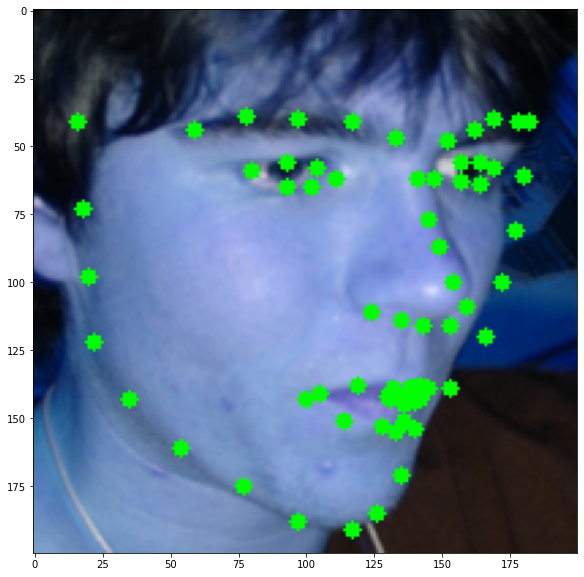

True

In [73]:
imagesmodelshape = (200,200)

#Read test image
imgname = 'combined/testset/'+images_test[66]
#imgname = 'randomimages/batman.png'
#set initial shape to mean shape
initial_prediction = initial_prediction.reshape(68,2).round().astype(int)

#Read image
img = cv2.imread(imgname)

#resize image to (200,200)
img = cv2.resize(img, imagesmodelshape)


shape = initial_prediction
#Predict offset from regressors

shapesresults = []
shapesresults.append(shape)
for i in range (0, 3):
    #hog_features = getHogFromLandmarks(shape, img)
    hog_features = getHogFromLandmarks(shape, img)
    offset = loadedregressors[i].predict([hog_features])
    shape = shape + offset.reshape((68,2))
    shape = shape.round().astype(int)
    shapesresults.append(shape)

for i in range (3, 6):
    hog_features = getHogFromLandmarks(shape, img)
    offset = loadedregressors[i].predict([hog_features])
    shape = shape + offset.reshape((68,2))
    shape = shape.round().astype(int)
    shapesresults.append(shape)

for i in range (6, 9):
    sift_feutures = getSiftFromLandmarks(shape, img)
    sift_features = loadedStandardModels[i-6].transform([sift_feutures])
    pca_features = loadedPCAModels[i-6].transform(sift_features)
    offset = loadedregressors[i].predict(pca_features)
    shape = shape + offset.reshape((68,2))
    shape = shape.round().astype(int)
    shapesresults.append(shape)


landmarks = shape

for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

# #saveimage
os.makedirs('screens', exist_ok=True)
l = len(os.listdir('screens'))
cv2.imwrite('screens/'+str(l)+'.jpg', img)

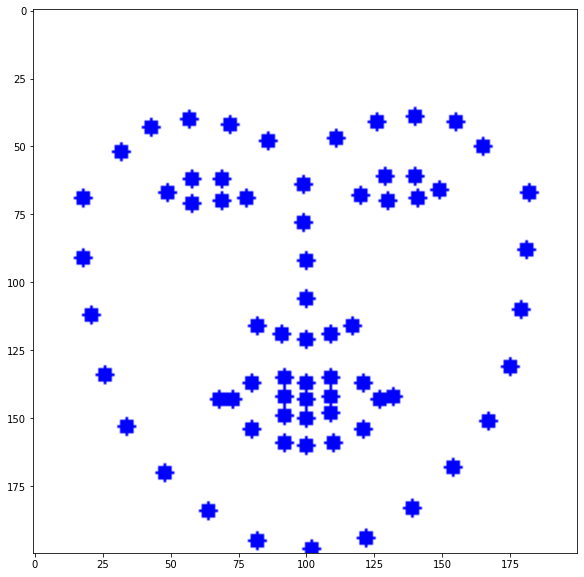

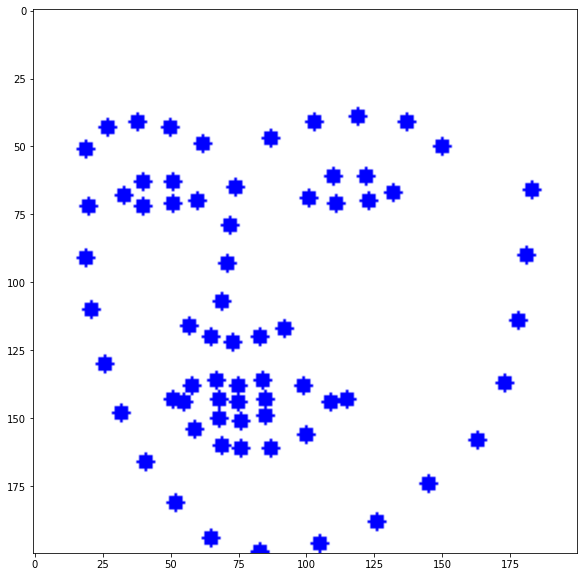

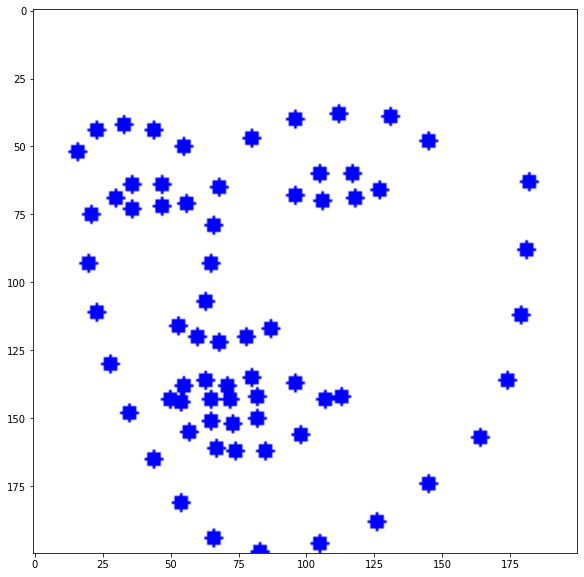

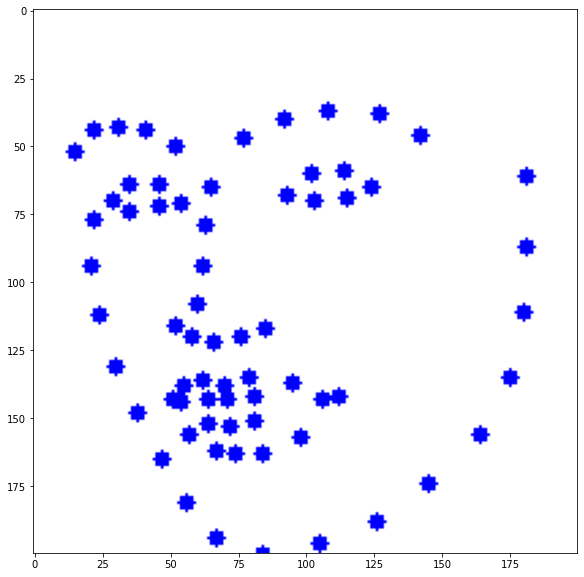

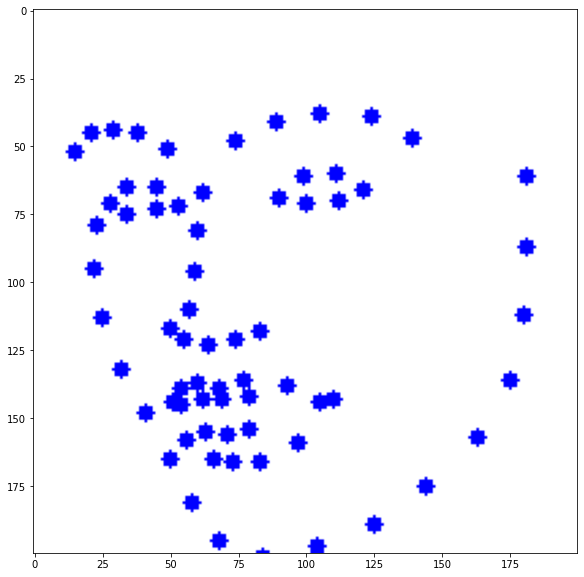

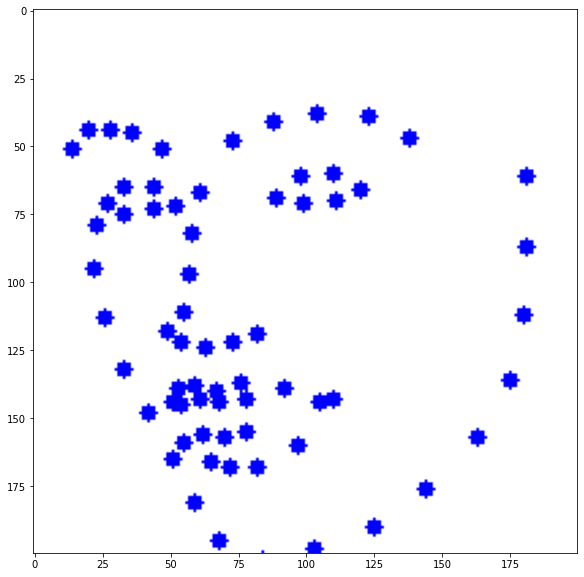

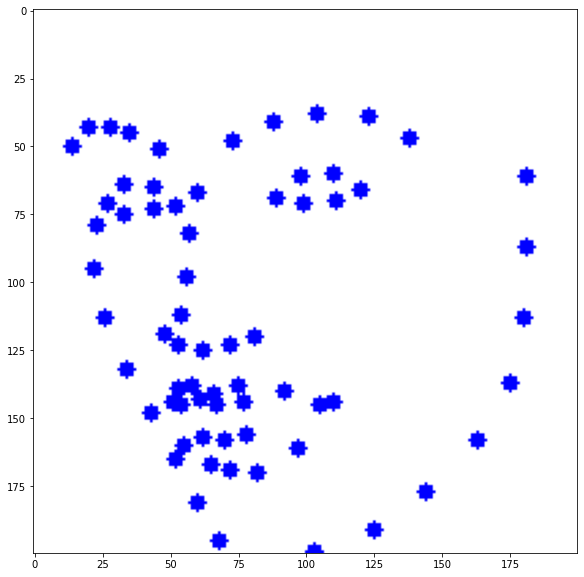

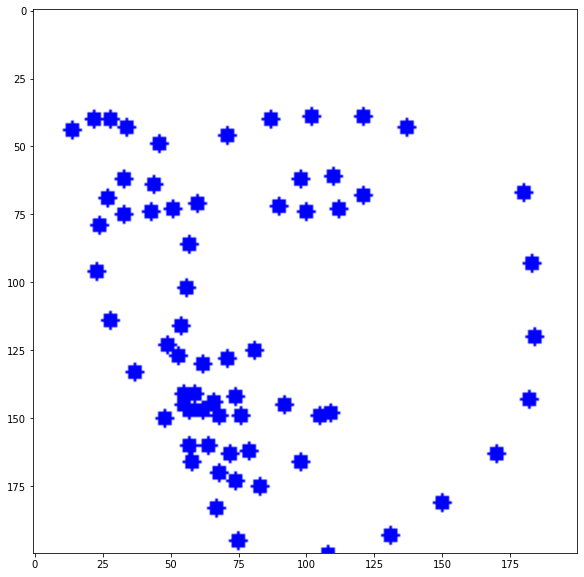

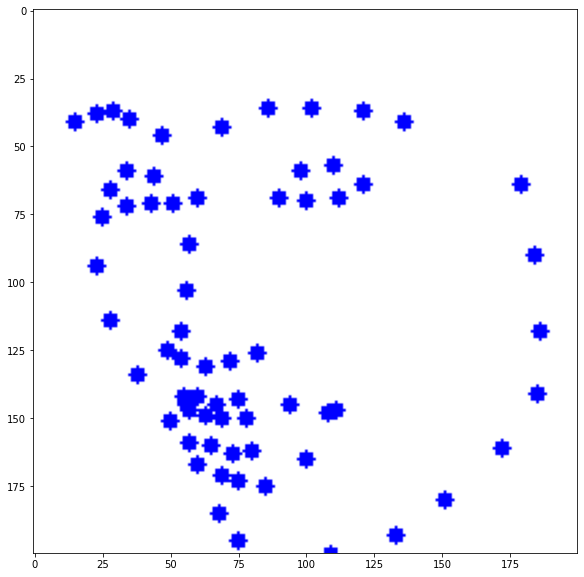

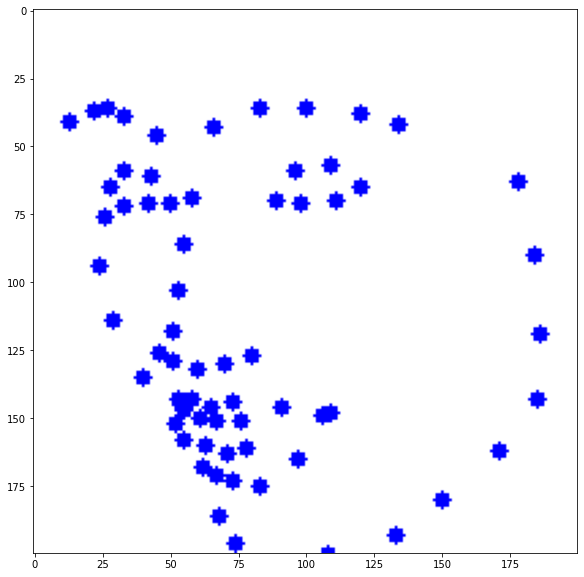

In [58]:
for shape in shapesresults: 
    landmarks = shape

    image = cv2.resize(cv2.imread('Untitled.png'), (200,200))

    for i in range(0,68):
        cv2.circle(image, (landmarks[i][0],landmarks[i][1]), 3, (0, 0, 255), -1)

    fig = plt.figure(figsize=(10,10))
    plt.imshow(image)

In [74]:
import dlib

In [79]:
#imgname = 'randomimages/test.jpg'
#imgname = 'datasets68/croppedHelen68_200/testset/'+images_test[299]
imgname = 'ada.jpg'

img = cv2.imread(imgname)
#copiedimg = cv2.resize(copiedimg, (200,200))

faceLandmarksPredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

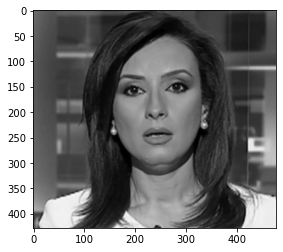

In [86]:
img = cv2.imread(imgname, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [80]:
faceDetector = dlib.get_frontal_face_detector()
face = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))[0]

In [82]:

landmarksd = faceLandmarksPredictor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), face).parts()
dlib_landmarks = []
for p in landmarksd:
    dlib_landmarks.append([p.x, p.y])

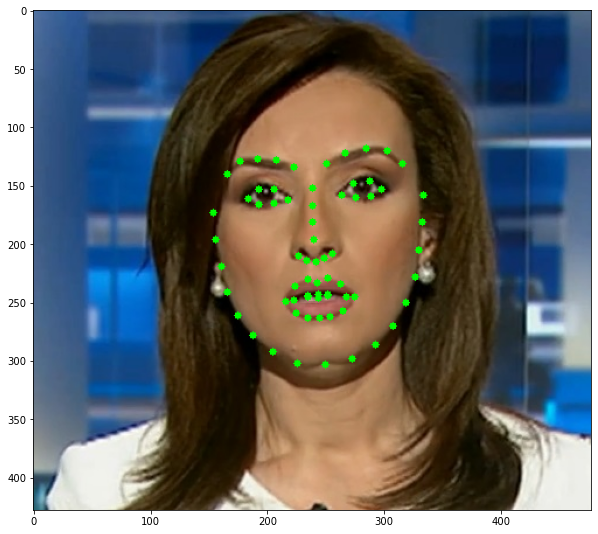

In [84]:
for i in range(0,len(dlib_landmarks)):
  cv2.circle(img, (dlib_landmarks[i][0],dlib_landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [43]:
face

rectangle(115,362,486,734)

In [ ]:
plt.imshow(copiedimg[face.top():face.bottom(), face.left():face.right()])
plt.show()